- create --name detr_env python=3.9 -y
- pip install transformers torch Pillow requests

In [1]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection 
import torch
from PIL import Image 
import numpy as np

c:\Users\HP\anaconda3\envs\detr_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


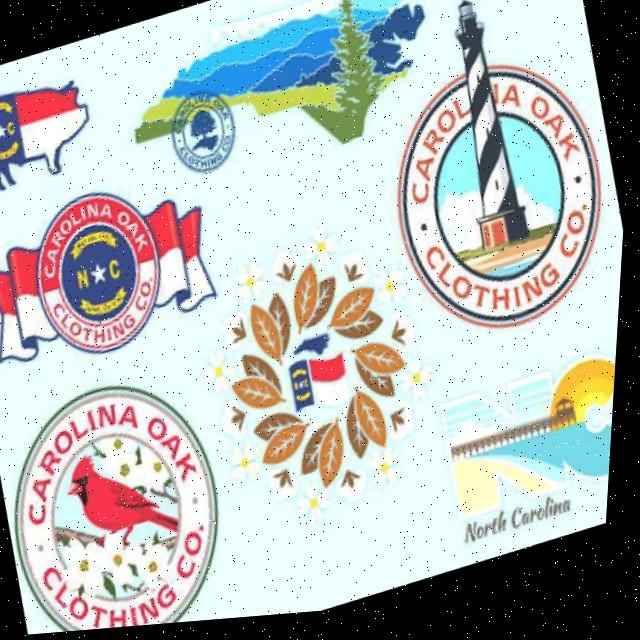

In [2]:
id = 12

src_dir_image = "id_card_dataset_detection/train/images/"
dst_dir_image = "id_card_dataset_detection/train/part_images/"
src_dir_label = "id_card_dataset_detection/train/labels/"
dst_dir_label = "id_card_dataset_detection/train/part_labels/"

images = os.listdir(dst_dir_image)
image_path = os.path.join(dst_dir_image, images[id])
image = Image.open(image_path)
image

In [7]:
#image= np.asarray(image)

In [3]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

In [4]:
inputs = processor(images=image, return_tensors="pt")

In [5]:
outputs = model(**inputs)

In [6]:
target_sizes = torch.tensor([image.size[::-1]])

In [7]:
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [8]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected clock with confidence 0.961 at location [16.1, 390.57, 216.91, 633.32]
Detected clock with confidence 0.995 at location [400.25, 1.73, 603.78, 327.32]


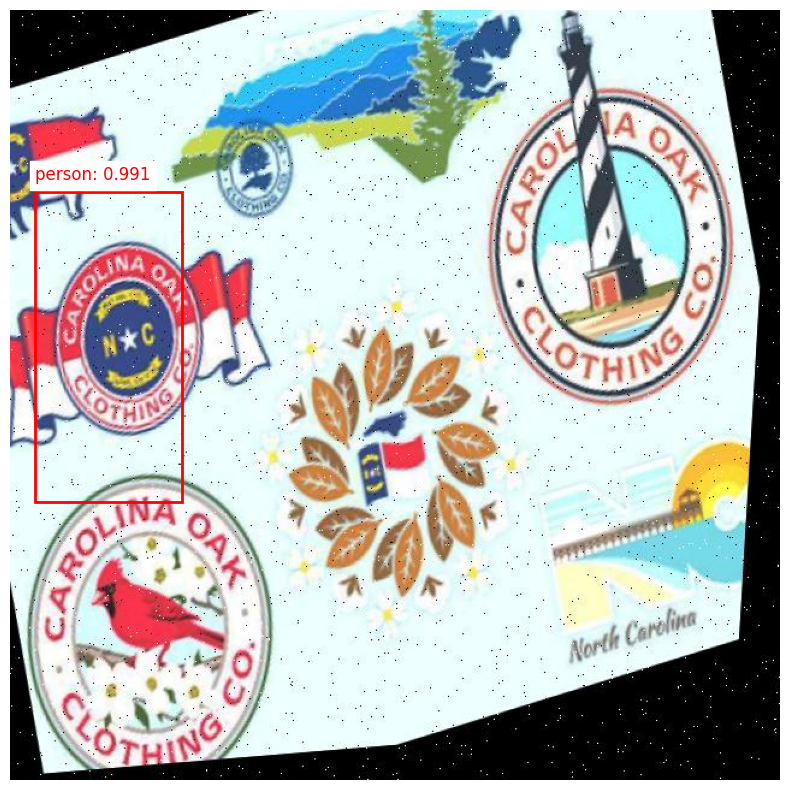

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

detections = [
    {"label": "person", "score": 0.991, "box": [20.67, 150.8, 142.17, 408.07]}
]

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

# Ajouter les boîtes englobantes
for detection in detections:
    label = detection["label"]
    score = detection["score"]
    box = detection["box"]  # Format [x_min, y_min, x_max, y_max]

    # Extraire les coordonnées de la boîte
    x_min, y_min, x_max, y_max = box

    # Calculer la largeur et la hauteur de la boîte
    width = x_max - x_min
    height = y_max - y_min

    # Ajouter une boîte rectangulaire à l'image
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # Ajouter le label et le score au-dessus de la boîte
    ax.text(
        x_min, y_min - 10,
        f"{label}: {score:.3f}",
        color="red", fontsize=12, backgroundcolor="white"
    )

# Afficher l'image
plt.axis("off")
plt.show()

In [10]:
import torch
from torch.optim import AdamW

# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-5)

# Définir l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [11]:
images = []

for filename in os.listdir(dst_dir_image):
    if any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
        file_path = os.path.join(dst_dir_image, filename)
        image = Image.open(file_path).convert("RGB")
        images.append(image)

In [12]:
print(len(images))

1986


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, annotations, processor):
        self.images = images
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Charger l'image
        annotation = self.annotations[idx]  # Charger les annotations associées
        encoding = self.processor(
            images=image,
            annotations=annotation,
            return_tensors="pt"
        )
        return encoding

# Exemple d'utilisation
#dataset = CustomDataset(images, labels, processor)
#data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
from tqdm import tqdm

# Boucle d'entraînement
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    print(f"Époque {epoch + 1}/{num_epochs}")
    loop = tqdm(data_loader, leave=True)
    
    for batch in loop:
        # Déplacer les données vers le GPU/CPU
        pixel_values = batch['pixel_values'].squeeze(1).to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch['labels']]

        # Calculer la perte
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Mise à jour du progress bar
        loop.set_description(f"Loss: {loss.item():.4f}")

In [ ]:
model.save_pretrained("./custom_detr_model")
processor.save_pretrained("./custom_detr_model")